# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

Project imports

In [1]:
import csv
import glob
import os
import pickle
import sys
import warnings
import zipfile
from functools import partial
from os.path import basename
from urllib.request import urlretrieve

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from tqdm import tqdm
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


Helper functions

In [2]:
def download_file(url, filepath):
    def reporthook(blocknum, blocksize, totalsize):
        readsofar = blocknum * blocksize
        if totalsize > 0:
            percent = readsofar * 1e2 / totalsize
            s = "\r%5.1f%% %*d / %d" % (
                percent, len(str(totalsize)), readsofar, totalsize)
            sys.stderr.write(s)
            if readsofar >= totalsize:
                sys.stderr.write("\n")
        else:
            sys.stderr.write("read %d\n" % (readsofar,))

    print("Download %s to %s" % (url, filepath))
    if not os.path.exists(filepath):
        urlretrieve(url, filepath, reporthook)
    print("Done")


def unzip(filepath, output_dir):
    with zipfile.ZipFile(filepath) as z:
        print("Unzip %s to %s" % (filepath, output_dir))
        for filename in z.namelist():
            if not os.path.exists(os.path.join(output_dir, filename)):
                print("Extract %s" % filename)
                z.extract(filename, output_dir)
                print("Done")

        z.extractall(output_dir)
        print("Done")


def get_input_files(dataset_url, output_directory):
    res = {}
    dataset_filename = dataset_url.rsplit('/', 1)[-1]
    filepath = os.path.join(output_directory, dataset_filename)

    download_file(dataset_url, filepath)
    unzip(filepath, output_directory)

    for input_file in glob.glob(os.path.join(output_directory, '*.p')):
        filename = ".".join(basename(input_file).split(".")[:-1])
        res[filename] = input_file

    return res


def read_csv(filepath, skip_header=True):
    res = {}
    if not os.path.exists(filepath):
        return res

    with open(filepath, mode='r') as infile:
        reader = csv.reader(infile)
        is_header = True
        for row in reader:
            if is_header and skip_header:
                is_header = False
                continue
            dkey, dvalue = row
            res[int(dkey)] = dvalue

        return res


def save_obj(obj, outfile):
    with open(outfile, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_obj(outfile):
    with open(outfile, 'rb') as f:
        return pickle.load(f)


def copy_array(arr):
    copy_arr = np.empty_like(arr)
    copy_arr[:] = arr
    return copy_arr


def read_image(path):
    bgr_image = cv2.imread(path)

    if len(bgr_image.shape) > 2 and bgr_image.shape[2] == 4:
        # remove 4th channel
        return cv2.cvtColor(bgr_image, cv2.COLOR_BGRA2BGR)
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)


def resize_image(image, shape=(32, 32)):
    return cv2.resize(image, shape)


def plot_train_results(results, filepath=None):
    plt.figure(figsize=(8, 8))
    for result in results:
        label, (epochs, accuracy) = result
        plt.plot(epochs, accuracy, label=label)

    plt.title('Results')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


def plot_distribution(classes, n_classes, title, filepath=None):
    plt.figure(figsize=(6, 3))
    plt.title('Distribution for {}'.format(title))
    plt.hist(classes, bins=n_classes)
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


def plot_features(features, classes=None, cols=None, squeeze=True, title=None, filepath=None):
    if squeeze:
        features = features.squeeze()

    if cols is None:
        cols = len(features)

    rows = len(features) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.subplots_adjust(top=0.8)

    if cols == rows == 1:
        axs = [axs]
    else:
        axs = axs.ravel()

    for row in range(rows):
        for col in range(cols):
            index = col + row * cols
            feature = features[index]
            axs[index].axis('off')
            if len(feature.shape) == 2:
                axs[index].imshow(feature, cmap="gray")
            else:
                axs[index].imshow(feature)

            if classes is not None:
                axs[index].set_title(classes[index])
    if title is not None:
        plt.suptitle(title, fontsize=12)

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


def filter_by_class_id(features, classes, class_id):
    class_indexes = np.where(classes == class_id)[0]
    return features[class_indexes], classes[class_indexes]


def select_random_features(features, classes, size, class_id=None):
    in_features = features
    in_classes = classes

    if class_id is not None:
        in_features, in_classes = filter_by_class_id(features, classes, class_id)

    indices = np.random.choice(len(in_features), size=size, replace=False)
    return in_features[indices], in_classes[indices]


def select_first_n_features(features, classes, size, class_id=None):
    in_features = features
    in_classes = classes

    if class_id is not None:
        in_features, in_classes = filter_by_class_id(features, classes, class_id)

    indices = range(size)
    return in_features[indices], in_classes[indices]


def plot_first_n_features(features, labels, feature_class_id, features_size=10, title=None):
    if title is None:
        title = "{} - {}".format(feature_class_id, classes_catalog[feature_class_id])
    features_res, classes_res = select_first_n_features(features, labels, size=features_size,
                                                        class_id=feature_class_id)
    plot_features(features_res, classes_res, cols=features_size, title=title)


def plot_random_n_features(features, labels, rnd_features_size=10, rnd_classes_size=5):
    for idx in range(rnd_classes_size):
        feature_class_id = unique_classes[idx]
        title = "{} - {}".format(feature_class_id, classes_catalog[feature_class_id])
        features_res, classes_res = select_random_features(features, labels, size=rnd_features_size,
                                                           class_id=feature_class_id)
        plot_features(features_res, classes_res, cols=rnd_features_size, title=title)


def plot_two_feature_sets(orig_features, orig_classes, mod_features, mod_classes, cols=None, title=None, filepath=None):
    assert len(orig_features) == len(orig_classes) == len(mod_features) == len(mod_classes)
    assert orig_features.shape[1:] == mod_features.shape[1:]

    if cols is None:
        cols = len(orig_features)

    res_features = orig_features
    res_classes = orig_classes

    res_features = np.concatenate((res_features, mod_features), axis=0)
    res_classes = np.concatenate((res_classes, mod_classes), axis=0)

    plot_features(res_features, res_classes, cols=cols, title=title, filepath=filepath)

In [3]:
DATASET_URL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
DATASET_NAMES_FILE = "signnames.csv"
OUTPUT_DIRECTORY = os.path.abspath("output")
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

input_files = get_input_files(DATASET_URL, OUTPUT_DIRECTORY)

Download https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip to /Users/volkodav/self_driving_car_proj/proj/CarND-Traffic-Sign-Classifier-Project/output/traffic-signs-data.zip
Done
Unzip /Users/volkodav/self_driving_car_proj/proj/CarND-Traffic-Sign-Classifier-Project/output/traffic-signs-data.zip to /Users/volkodav/self_driving_car_proj/proj/CarND-Traffic-Sign-Classifier-Project/output
Done


In [4]:
classes_catalog = read_csv(DATASET_NAMES_FILE)
training_file = input_files["train"]
validation_file = input_files["valid"]
testing_file = input_files["test"]

assert os.path.exists(training_file)
assert os.path.exists(validation_file)
assert os.path.exists(testing_file)

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)
assert len(X_test) == len(y_test)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
unique_classes, unique_classes_size = np.unique(y_train, return_counts=True)
n_classes = len(unique_classes)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

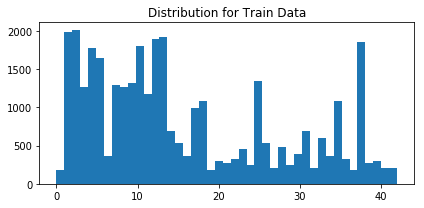

In [6]:
plot_distribution(y_train, n_classes, 'Train Data')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
datagen = ImageDataGenerator(
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    rotation_range=10.0
)

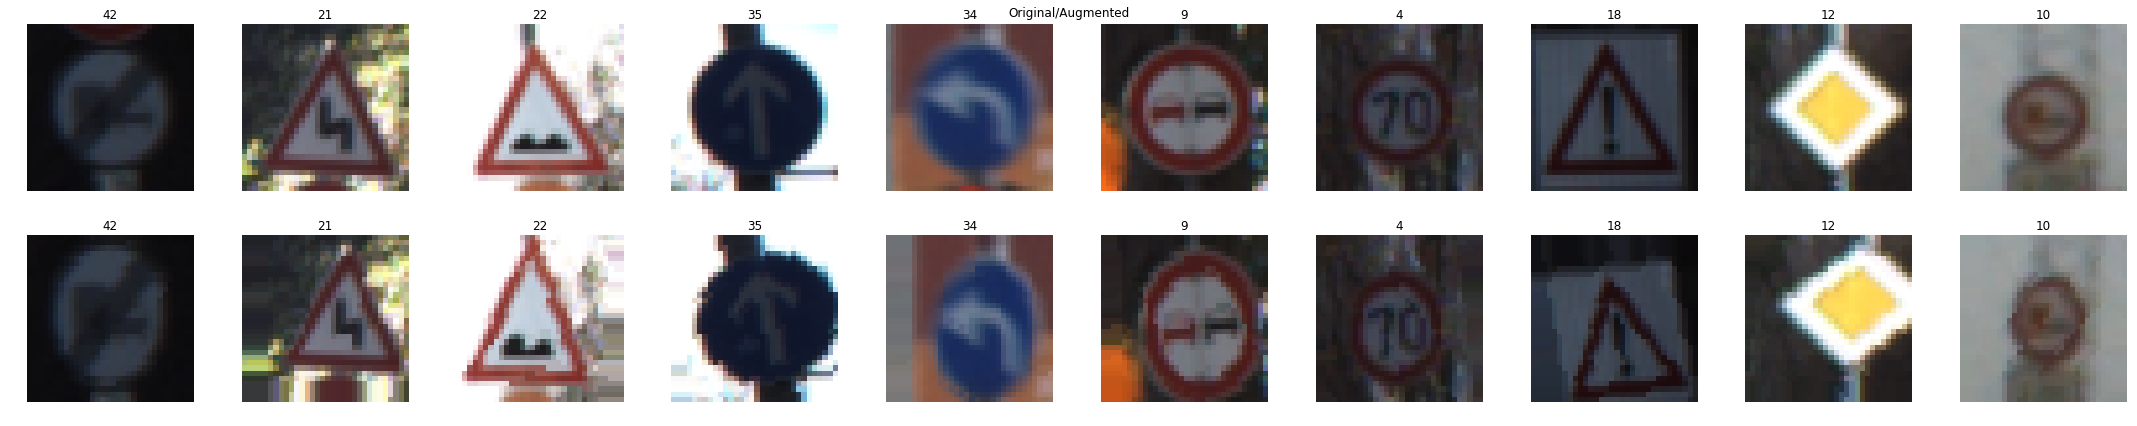

In [8]:
classes_to_plot = 10
rnd_features, rnd_classes = select_random_features(X_train, y_train, classes_to_plot)
mod_rnd_features, mod_rnd_classes = datagen.flow(rnd_features, rnd_classes, batch_size=classes_to_plot,
                                                 shuffle=False).next()
mod_rnd_features = mod_rnd_features.astype(np.uint8)

plot_two_feature_sets(rnd_features, rnd_classes, mod_rnd_features, mod_rnd_classes, title="Original/Augmented")

In [9]:
train_images_augmented_npy = os.path.join(OUTPUT_DIRECTORY, "train_images_enriched.npy")
train_classes_augmented_npy = os.path.join(OUTPUT_DIRECTORY, "train_classes_enriched.npy")

In [10]:
def augmented_data_available():
    return os.path.exists(train_images_augmented_npy) and os.path.exists(train_classes_augmented_npy)


def load_augmented_data():
    return load_obj(train_images_augmented_npy), load_obj(train_classes_augmented_npy)


def save_augmented_data(images):
    (train_images_enriched, train_classes_enriched) = images
    save_obj(train_images_enriched, outfile=train_images_augmented_npy)
    save_obj(train_classes_enriched, outfile=train_classes_augmented_npy)


def validate_augmented_data_consistency(in1, in2):
    (train_images_enriched1, train_classes_enriched1) = in1
    (train_images_enriched2, train_classes_enriched2) = in2

    assert np.array_equal(train_images_enriched1, train_images_enriched2)
    assert np.array_equal(train_classes_enriched1, train_classes_enriched2)


def augment_data(features, classes, unique_classes, unique_classes_size, optimal_class_size=5000):
    res_features = copy_array(features)
    res_classes = copy_array(classes)

    # find avarage
    # optimal_size = np.mean(unique_classes_size)
    # find max number of occurrences across classes
    # optimal_class_size = unique_classes_size[np.argmax(unique_classes_size)]
    classes_with_missing_samples = np.where(unique_classes_size < optimal_class_size)[0]
    num_of_classes_with_missing_samples = len(classes_with_missing_samples)

    print("Classes to update: {}".format(num_of_classes_with_missing_samples))

    classes_processed = 0
    for idx, class_id in tqdm(enumerate(unique_classes)):
        num_of_occurrences = unique_classes_size[idx]
        if num_of_occurrences < optimal_class_size:
            missing_samples_size = int(optimal_class_size - num_of_occurrences)
            class_indexes = np.where(classes == class_id)[0]
            selected_features = features[class_indexes]
            selected_classes = classes[class_indexes]

            features_size = len(selected_features)
            quotient, remainder = divmod(missing_samples_size, features_size)

            if quotient > 0:
                for idx, new_images in enumerate(
                        datagen.flow(selected_features, selected_classes, batch_size=features_size, shuffle=False)):
                    (new_features, new_classes) = new_images
                    new_features = new_features.astype(np.uint8)

                    assert len(new_features) == len(new_classes) == features_size

                    res_features = np.concatenate((res_features, new_features), axis=0)
                    res_classes = np.concatenate((res_classes, new_classes), axis=0)

                    if idx + 1 == quotient:
                        break
            if remainder > 0:
                (new_features, new_classes) = datagen.flow(selected_features, selected_classes,
                                                           batch_size=remainder, shuffle=False).next()
                new_features = new_features.astype(np.uint8)

                assert len(new_features) == len(new_classes) == remainder

                res_features = np.concatenate((res_features, new_features), axis=0)
                res_classes = np.concatenate((res_classes, new_classes), axis=0)

            classes_processed += 1

    return res_features, res_classes


train_images_augmented = train_classes_augmented = None
if augmented_data_available():
    train_images_augmented, train_classes_augmented = load_augmented_data()
else:
    train_images_augmented, train_classes_augmented = augment_data(X_train, y_train, unique_classes,
                                                                   unique_classes_size)
    save_augmented_data((train_images_augmented, train_classes_augmented))

print("Validate augmented data consistency")
validate_augmented_data_consistency((train_images_augmented, train_classes_augmented), load_augmented_data())
print("Done")

Validate augmented data consistency
Done


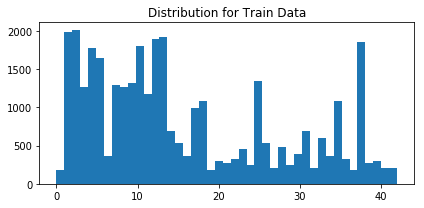

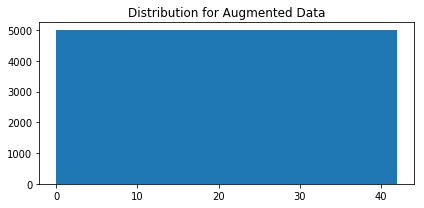

In [11]:
plot_distribution(y_train, n_classes, 'Train Data')
plot_distribution(train_classes_augmented, n_classes, 'Augmented Data')

In [12]:
# Use augmented training data by default
X_train, y_train = train_images_augmented, train_classes_augmented

In [13]:
train_images_normalized_npy = os.path.join(OUTPUT_DIRECTORY, "train_images_normalized.npy")
valid_images_normalized_npy = os.path.join(OUTPUT_DIRECTORY, "valid_images_normalized.npy")
test_images_normalized_npy = os.path.join(OUTPUT_DIRECTORY, "test_images_normalized.npy")

In [14]:
def normalized_images_available():
    return os.path.exists(train_images_normalized_npy) \
           and os.path.exists(valid_images_normalized_npy) \
           and os.path.exists(test_images_normalized_npy)


def load_normalized_images():
    return load_obj(train_images_normalized_npy), load_obj(valid_images_normalized_npy), \
           load_obj(test_images_normalized_npy)


def save_normalized_images(images):
    (train_images_normalized, valid_images_normalized, test_images_normalized) = images

    save_obj(train_images_normalized, train_images_normalized_npy)
    save_obj(valid_images_normalized, valid_images_normalized_npy)
    save_obj(test_images_normalized, test_images_normalized_npy)


def normalize_images_adapthist(images):
    # images = images[:10]
    images_gray = np.dot(images[:, :, :, :3], [0.2989, 0.587, 0.114])
    images_gray = images_gray / 255.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in tqdm(range(len(images_gray))):
            images_gray[i] = exposure.equalize_adapthist(images_gray[i])

    images_gray = images_gray.reshape(-1, images_gray.shape[1], images_gray.shape[2], 1).astype(np.float32)
    return images_gray


def normalize_images_simple(images):
    images_gray_mean = np.mean(images, axis=3, keepdims=True)
    assert images_gray_mean.shape[:-1] == images.shape[:-1]

    images_gray_norm = (images_gray_mean - 128) / 128
    assert images_gray_norm.shape == images_gray_mean.shape

    return images_gray_norm


def normalize_images(images):
    # images = images[:10]
    return normalize_images_adapthist(images)


def validate_norm_data_consistency(in1, in2):
    (train_images_normalized1,
     valid_images_normalized1,
     test_images_normalized1) = in1
    (train_images_normalized2,
     valid_images_normalized2,
     test_images_normalized2) = in2

    assert np.array_equal(train_images_normalized1, train_images_normalized2)
    assert np.array_equal(valid_images_normalized1, valid_images_normalized2)
    assert np.array_equal(test_images_normalized1, test_images_normalized2)


train_images_normalized = valid_images_normalized = test_images_normalized = None

if normalized_images_available():
    print("Preloading data")
    train_images_normalized, valid_images_normalized, test_images_normalized = load_normalized_images()
else:
    print("Normalizing data")
    train_images_normalized = normalize_images(X_train)
    valid_images_normalized = normalize_images(X_valid)
    test_images_normalized = normalize_images(X_test)
    print("Saving normalized data")
    save_normalized_images((train_images_normalized, valid_images_normalized, test_images_normalized))

print("Validate normalized data consistency")
validate_norm_data_consistency((train_images_normalized, valid_images_normalized, test_images_normalized),
                               load_normalized_images())
print("Done")

Preloading data
Validate normalized data consistency
Done


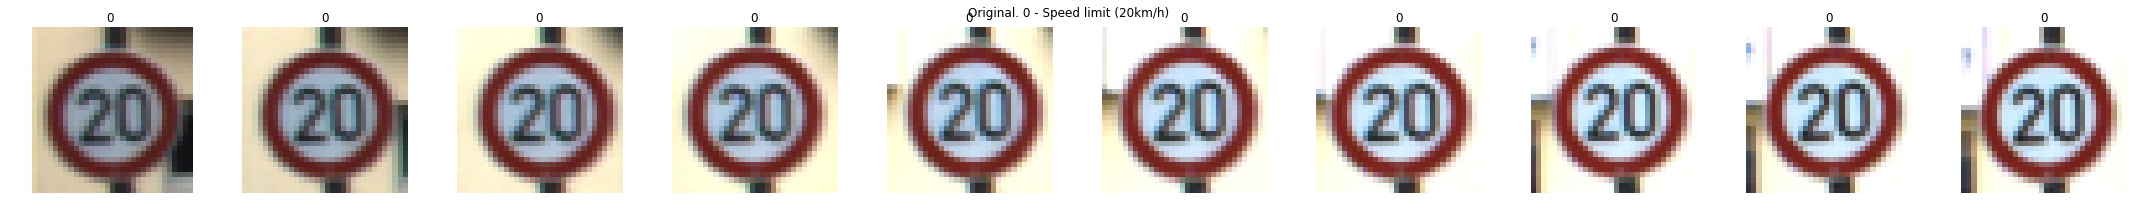

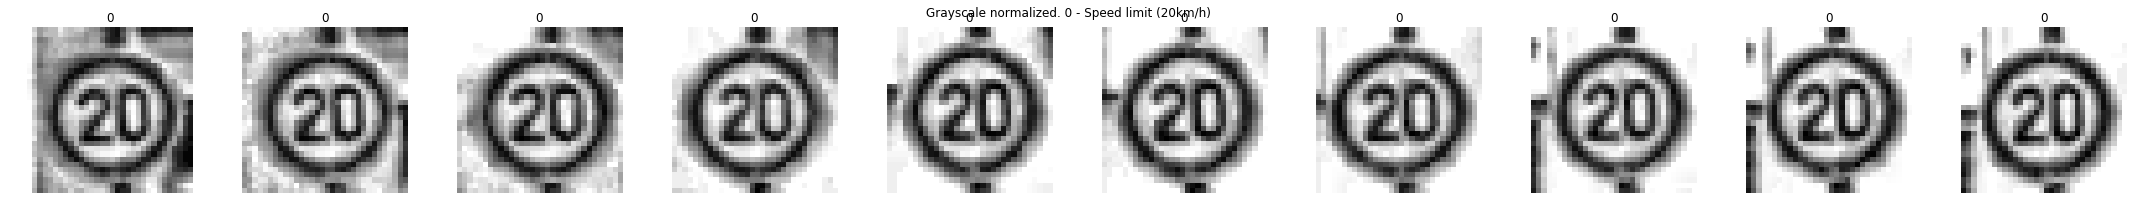

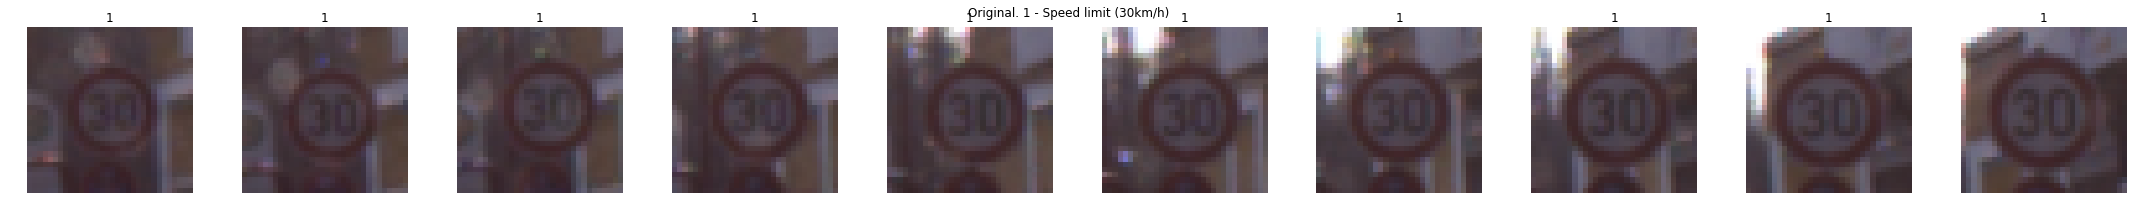

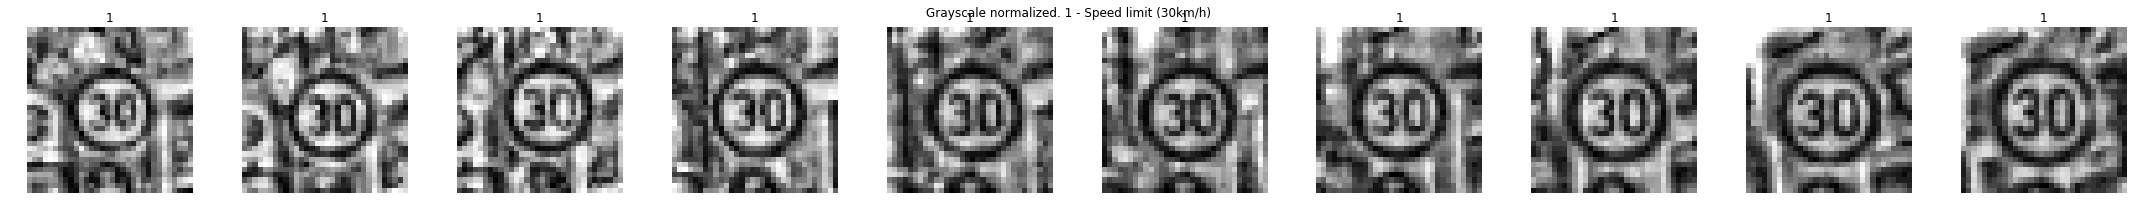

In [15]:
classes_to_plot = 2
for idx in range(classes_to_plot):
    feature_class_id = unique_classes[idx]
    plot_first_n_features(X_train, y_train, feature_class_id,
                          title="Original. {} - {}".format(feature_class_id, classes_catalog[feature_class_id]))
    plot_first_n_features(train_images_normalized, y_train, feature_class_id,
                          title="Grayscale normalized. {} - {}".format(feature_class_id,
                                                                       classes_catalog[feature_class_id]))

We normalized pixel values to be in the range of 0-1. This should help us with gradient decent.

Histogram Equalization reduce noise in images and thus make the model more robust in predicting same images. 

The training data was augmented to obtain 5000 samples per class. The additional data was generated to increase samples for training, which in turn would make training more robust. The newly generated dataset includes normalized original data, and newly generated data (by randomly introducing rotation, x-translation, y-translation, sheer factor and zoom factor to the original data). The new dataset is balanced and had already been pre-processed for normalizing contrast and illumination.

### Model Architecture

In [16]:
EPOCHS = 20
BATCH_SIZE = 128
(height, width, depth) = train_images_normalized.shape[1:]

In [17]:
def lenetMultiDropoutsBefore45(x, keep_prob, n_classes):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)

    # Dropout
    dr0 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(dr0, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)

    # Dropout
    dr1 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = {n_classes}.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    # logits = tf.matmul(fc2, fc3_W) + fc3_b
    logits = tf.matmul(dr1, fc3_W) + fc3_b

    return logits, {"conv1": conv1, "conv2": conv2, "fc0": fc0, "fc1": fc1, "fc2": fc2, "logits": logits}


def evaluate(X_data, y_data, accuracy_operation, x, y, keep_prob, keep_prob_value=1.0):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_value})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def train_model(train_features, train_classes, valid_features, valid_classes, model_config, keep_prob_value=0.5,
                model_name="lenet", desc=None, output_dir=OUTPUT_DIRECTORY):
    print("Train model {}".format(model_name))

    if desc is None:
        desc = model_name

    x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params = model_config()
    saver = tf.train.Saver()

    results = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        print("Training...")
        print()
        for epoch in range(EPOCHS):
            train_features, train_classes = shuffle(train_features, train_classes)
            for offset in tqdm(range(0, len(train_features), BATCH_SIZE)):
                end = offset + BATCH_SIZE
                batch_x, batch_y = train_features[offset:end], train_classes[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_value})

            validation_accuracy = evaluate(valid_features, valid_classes, accuracy_operation, x, y, keep_prob)
            epoch_number = epoch + 1
            print("EPOCH {} ...".format(epoch_number))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            results.append([epoch_number, validation_accuracy])

        saver.save(sess, os.path.join(output_dir, model_name))
        print("Model saved")

        # trasform [[epoch, accuracy], [epoch, accuracy]] -> [[epoch, epoch], [accuracy, accuracy]]
        return desc, np.array(results).T


def evaluate_model(in_features, in_classes, model_config,
                   keep_prob_value=1.0, model_name="lenet", desc=None, output_dir=OUTPUT_DIRECTORY):
    print("Evaluate model {}".format(model_name))

    if desc is None:
        desc = model_name

    model_file = os.path.join(output_dir, model_name)

    x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params = model_config()
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_file)
        return evaluate(in_features, in_classes, accuracy_operation, x, y, keep_prob, keep_prob_value)


def calc_top_k(in_features, in_classes, model_config, top_k_value=5,
               keep_prob_value=1.0, model_name="lenet", desc=None, output_dir=OUTPUT_DIRECTORY):
    print("Calculate top_k model {}".format(model_name))

    if desc is None:
        desc = model_name

    model_file = os.path.join(output_dir, model_name)

    x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params = model_config()
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_file)
        sess = tf.get_default_session()
        top_k_results = sess.run(tf.nn.top_k(tf.nn.softmax(logits), top_k_value),
                                 feed_dict={x: in_features, keep_prob: keep_prob_value})
        return top_k_results


def calc_probability(in_features, in_classes, model_config,
                     keep_prob_value=1.0, model_name="lenet", desc=None, output_dir=OUTPUT_DIRECTORY):
    print("Calculate probability model {}".format(model_name))

    if desc is None:
        desc = model_name

    model_file = os.path.join(output_dir, model_name)

    x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params = model_config()
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_file)
        sess = tf.get_default_session()
        predicted_classes = sess.run(tf.argmax(logits, 1),
                                     feed_dict={x: in_features, y: in_classes, keep_prob: keep_prob_value})
        assert in_classes.shape == predicted_classes.shape
        return predicted_classes


def model_multi_dropouts_before45_config():
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, (None, height, width, depth), name="X")
    y = tf.placeholder(tf.int32, (None), name="Y")
    one_hot_y = tf.one_hot(y, n_classes)
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    rate = 0.001
    logits, cnn_params = lenetMultiDropoutsBefore45(x, keep_prob, n_classes)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params

In [18]:
model_metrics_file = os.path.join(OUTPUT_DIRECTORY, "model_metrics.pickle")


def model_metrics_available():
    return os.path.exists(model_metrics_file)


def save_model_metrics(metrics):
    save_obj(metrics, model_metrics_file)


def load_model_metrics():
    return load_obj(model_metrics_file)


def plot_confusion_matrix(cm):
    cm = [row / sum(row) for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()


def print_confusion_matrix(cm, cm_index_labels=None, classes_catalog=classes_catalog, order_desc=False):
    results = []
    for idx, row in enumerate(cm):
        accuracy = round(row[idx] / sum(row) * 100, 2)
        class_id = None
        if cm_index_labels is not None:
            class_id = cm_index_labels[idx]
        else:
            class_id = idx
        class_name = classes_catalog[class_id]
        results.append((accuracy, class_id, class_name))

    total_accuracy = []
    for result in sorted(results, key=lambda x: x[0], reverse=order_desc):
        (accuracy, class_id, class_name) = result
        print('{}% - {} / {}'.format(accuracy, class_id, class_name))
        total_accuracy.append(accuracy)

    print("Accuracy: Mean: {}% Std: {}".format(np.around(np.mean(total_accuracy), decimals=3),
                                               np.around(np.std(total_accuracy), decimals=3)))

Modified LeNet Architecture

Input (32x32x3) -> Convolutional 5x5x6 -> ReLu -> MaxPool (stride of 2) -> Convolutional 5x5x16 -> ReLu -> MaxPool (stride of 2) -> Flatten (400) -> Fully Connected (120 units) -> ReLu -> Dropout -> Fully Connected (84 units) -> ReLu -> Dropout -> Fully Connected (43 units, output)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
train_setups = [
    partial(train_model, train_features=train_images_normalized, train_classes=y_train,
            valid_features=valid_images_normalized,
            valid_classes=y_valid, model_config=model_multi_dropouts_before45_config,
            desc="NDR 45 Grayscale normalized", model_name="ndr45_train_images_normalized_model"),
]

In [20]:
results = []
if model_metrics_available():
    results = load_model_metrics()
else:
    for train_setup in train_setups:
        result = train_setup()
        print("Result: ", result)
        results.append(result)
    print("Saving model metrics")
    save_model_metrics(results)

print("Done")

Done


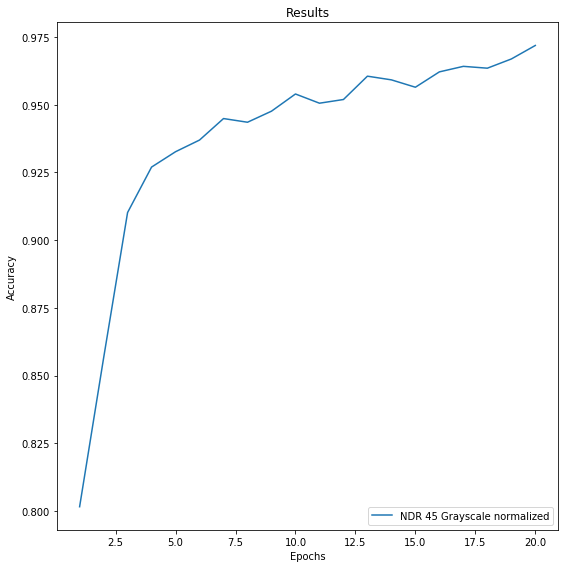

In [21]:
plot_train_results(results, os.path.join(OUTPUT_DIRECTORY, "train_results.png"))

Calculate probability model ndr45_train_images_normalized_model
98.94% - 39 / Keep left
98.9% - 16 / Vehicles over 3.5 metric tons prohibited
98.86% - 32 / End of all speed and passing limits
98.44% - 36 / Go straight or right
98.38% - 37 / Go straight or left
98.34% - 6 / End of speed limit (80km/h)
98.28% - 17 / No entry
98.22% - 14 / Stop
98.02% - 15 / No vehicles
97.96% - 33 / Turn right ahead
97.94% - 35 / Ahead only
97.84% - 13 / Yield
97.38% - 42 / End of no passing by vehicles over 3.5 metric tons
97.34% - 41 / End of no passing
97.24% - 40 / Roundabout mandatory
97.18% - 22 / Bumpy road
96.52% - 20 / Dangerous curve to the right
96.36% - 34 / Turn left ahead
96.34% - 38 / Keep right
96.26% - 19 / Dangerous curve to the left
95.78% - 31 / Wild animals crossing
95.64% - 12 / Priority road
95.4% - 25 / Road work
95.06% - 24 / Road narrows on the right
94.86% - 10 / No passing for vehicles over 3.5 metric tons
93.62% - 0 / Speed limit (20km/h)
93.6% - 27 / Pedestrians
93.52% - 9 /

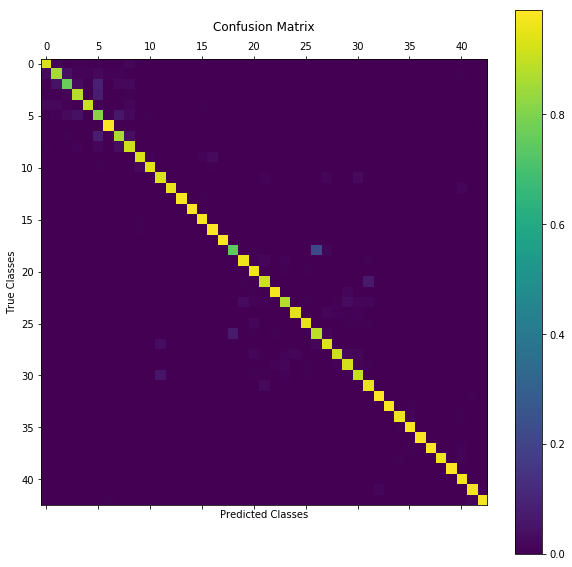

Calculate probability model ndr45_train_images_normalized_model
100.0% - 0 / Speed limit (20km/h)
100.0% - 6 / End of speed limit (80km/h)
100.0% - 10 / No passing for vehicles over 3.5 metric tons
100.0% - 15 / No vehicles
100.0% - 17 / No entry
100.0% - 19 / Dangerous curve to the left
100.0% - 22 / Bumpy road
100.0% - 28 / Children crossing
100.0% - 31 / Wild animals crossing
100.0% - 32 / End of all speed and passing limits
100.0% - 33 / Turn right ahead
100.0% - 34 / Turn left ahead
100.0% - 35 / Ahead only
100.0% - 36 / Go straight or right
100.0% - 37 / Go straight or left
100.0% - 38 / Keep right
100.0% - 39 / Keep left
100.0% - 40 / Roundabout mandatory
100.0% - 41 / End of no passing
100.0% - 42 / End of no passing by vehicles over 3.5 metric tons
99.58% - 13 / Yield
99.05% - 4 / Speed limit (70km/h)
98.67% - 7 / Speed limit (100km/h)
98.67% - 11 / Right-of-way at the next intersection
98.57% - 12 / Priority road
98.33% - 16 / Vehicles over 3.5 metric tons prohibited
98.33% -

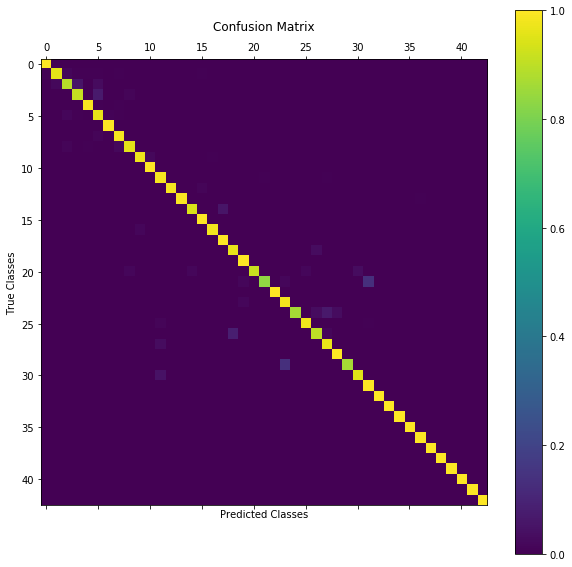

Calculate probability model ndr45_train_images_normalized_model
100.0% - 14 / Stop
100.0% - 16 / Vehicles over 3.5 metric tons prohibited
100.0% - 34 / Turn left ahead
100.0% - 36 / Go straight or right
100.0% - 39 / Keep left
99.63% - 31 / Wild animals crossing
99.23% - 35 / Ahead only
99.17% - 9 / No passing
99.17% - 13 / Yield
98.89% - 29 / Bicycles crossing
98.67% - 23 / Slippery road
98.33% - 32 / End of all speed and passing limits
98.33% - 37 / Go straight or left
98.26% - 12 / Priority road
98.1% - 33 / Turn right ahead
97.78% - 20 / Dangerous curve to the right
97.71% - 25 / Road work
96.67% - 0 / Speed limit (20km/h)
96.67% - 40 / Roundabout mandatory
96.52% - 10 / No passing for vehicles over 3.5 metric tons
96.19% - 15 / No vehicles
95.8% - 38 / Keep right
95.24% - 5 / Speed limit (80km/h)
95.07% - 2 / Speed limit (50km/h)
95.0% - 19 / Dangerous curve to the left
94.39% - 4 / Speed limit (70km/h)
94.0% - 6 / End of speed limit (80km/h)
93.61% - 1 / Speed limit (30km/h)
93.6

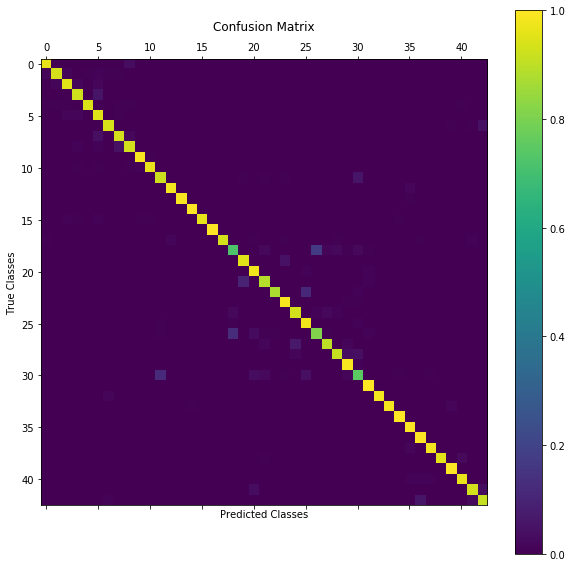

In [22]:
train_features_predicted_classes = calc_probability(train_images_normalized, y_train,
                                                    model_config=model_multi_dropouts_before45_config,
                                                    desc="NDR 45 Grayscale normalized (Train)",
                                                    model_name="ndr45_train_images_normalized_model")
train_features_cm = confusion_matrix(y_train, train_features_predicted_classes)
print_confusion_matrix(train_features_cm, order_desc=True)
plot_confusion_matrix(train_features_cm)

valid_features_predicted_classes = calc_probability(valid_images_normalized, y_valid,
                                                    model_config=model_multi_dropouts_before45_config,
                                                    desc="NDR 45 Grayscale normalized (Valid)",
                                                    model_name="ndr45_train_images_normalized_model")
valid_features_cm = confusion_matrix(y_valid, valid_features_predicted_classes)
print_confusion_matrix(valid_features_cm, order_desc=True)
plot_confusion_matrix(valid_features_cm)

test_features_predicted_classes = calc_probability(test_images_normalized, y_test,
                                                   model_config=model_multi_dropouts_before45_config,
                                                   desc="NDR 45 Grayscale normalized (Test)",
                                                   model_name="ndr45_train_images_normalized_model")
test_features_cm = confusion_matrix(y_test, test_features_predicted_classes)
print_confusion_matrix(test_features_cm, order_desc=True)
plot_confusion_matrix(test_features_cm)

To train the model we used:
- AdamOptimizer for managing learning rate
- Batch Size: 128
- Epochs: 20
- Variables initialized with normal distribution (mean=0, std dev=0.1)
- Biases initialized with zeros

To get good score we used:

- Preproceesed data with adaptive histogram equalization to make protect training from varying contrast and illumination.
- Augmented training data by randomly introducing rotation, horizontal and vertical shift, and scaling.
- Trained with LeNet Architecture as the problem description is similar to image classification problem on which LeNet was applied. Dropouts were introduced to avoid overfitting.
- Decided batch size and epoch by using generated validation and test set.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [23]:
new_features_with_classes = [(resize_image(read_image(path)), int(basename(path).split(".")[-2])) for path in
                             glob.glob('images/*.jpg')]
(new_features, new_classes) = zip(*new_features_with_classes)
new_features = np.array(new_features).astype(np.float32)
new_classes = np.array(new_classes)

assert new_features.shape[1:] == X_train.shape[1:]

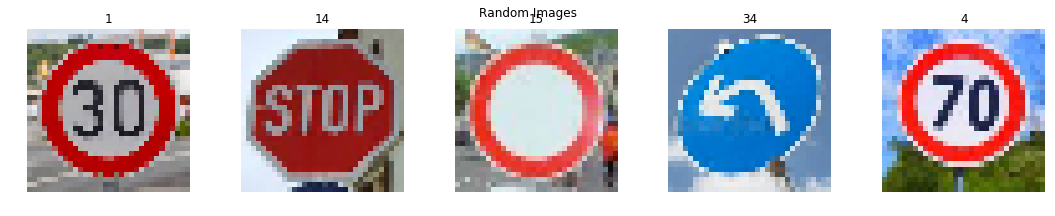

In [35]:
plot_features(new_features.astype(np.uint8), new_classes, title="Random Images")

In [25]:
new_features_normalized = normalize_images(new_features)

100%|██████████| 5/5 [00:00<00:00, 94.94it/s]


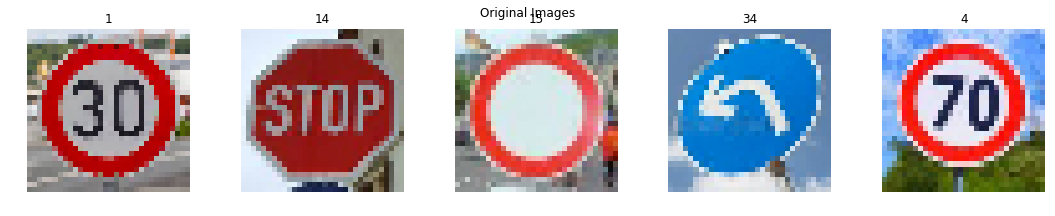

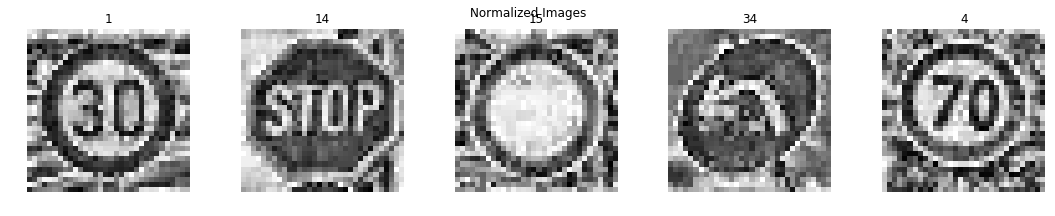

In [26]:
plot_features(new_features.astype(np.uint8), new_classes, title="Original Images")
plot_features(new_features_normalized, new_classes, title="Normalized Images")

### Predict the Sign Type for Each Image

In [27]:
new_features_predicted_classes = calc_probability(new_features_normalized,
                                                  new_classes,
                                                  model_config=model_multi_dropouts_before45_config,
                                                  desc="NDR 45 Grayscale normalized (New Images)",
                                                  model_name="ndr45_train_images_normalized_model")

Calculate probability model ndr45_train_images_normalized_model


### Analyze Performance

100.0% - 1 / Speed limit (30km/h)
100.0% - 14 / Stop
100.0% - 15 / No vehicles
100.0% - 34 / Turn left ahead
100.0% - 4 / Speed limit (70km/h)
Accuracy: Mean: 100.0% Std: 0.0


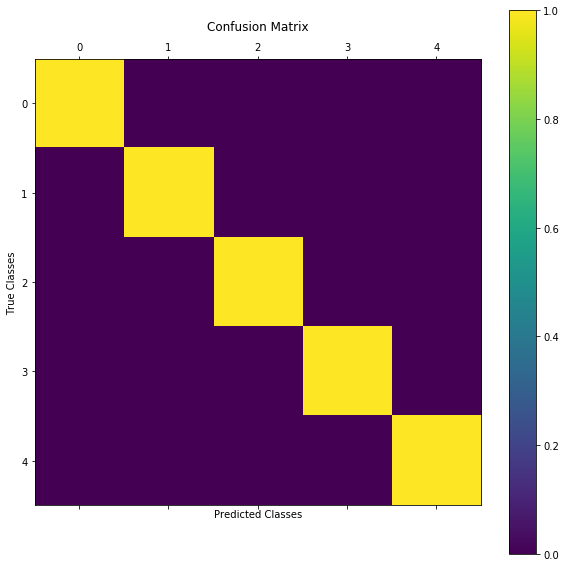

In [28]:
# cm_index_labels need to lookup for real class_id in confusion matrix
# see: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
new_features_cm = confusion_matrix(new_classes, new_features_predicted_classes, labels=new_classes)
print_confusion_matrix(new_features_cm, cm_index_labels=new_classes, order_desc=True)
plot_confusion_matrix(new_features_cm)

As we can see the model is able to predict correctly on newly provided images with accuracy of 100%. This is a good sign that the model performs well on real-world data.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [29]:
def plot_top_k(in_features, in_classes, top_k):
    rows = top_k[0].shape[0]
    cols = top_k[0].shape[1] + 1

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5))
    fig.subplots_adjust(top=0.8)
    axs = axs.ravel()
    for row in range(rows):
        for col in range(cols):
            index = col + row * cols
            feature = None
            class_id = -1
            predicted_prcnt = -1
            if col == 0:
                feature = in_features[row].squeeze()
                class_id = in_classes[row]
            else:
                class_id = top_k[1][row][col - 1]
                predicted_prcnt = 100 * top_k[0][row][col - 1]
                class_indexes = np.where(y_test == class_id)[0]
                feature = test_images_normalized[class_indexes][0].squeeze()
            axs[index].axis('off')
            if len(feature.shape) == 2:
                axs[index].imshow(feature, cmap="gray")
            else:
                axs[index].imshow(feature)

            if col == 0:
                axs[index].set_title('Original: {}'.format(class_id))
            else:
                axs[index].set_title('Predicted: {} ({:.0f}%)'.format(class_id, predicted_prcnt))
    plt.show()

In [30]:
top_k_results = calc_top_k(new_features_normalized, new_classes,
                           model_config=model_multi_dropouts_before45_config,
                           desc="NDR 45 Grayscale normalized (New Images)",
                           model_name="ndr45_train_images_normalized_model")

Calculate top_k model ndr45_train_images_normalized_model


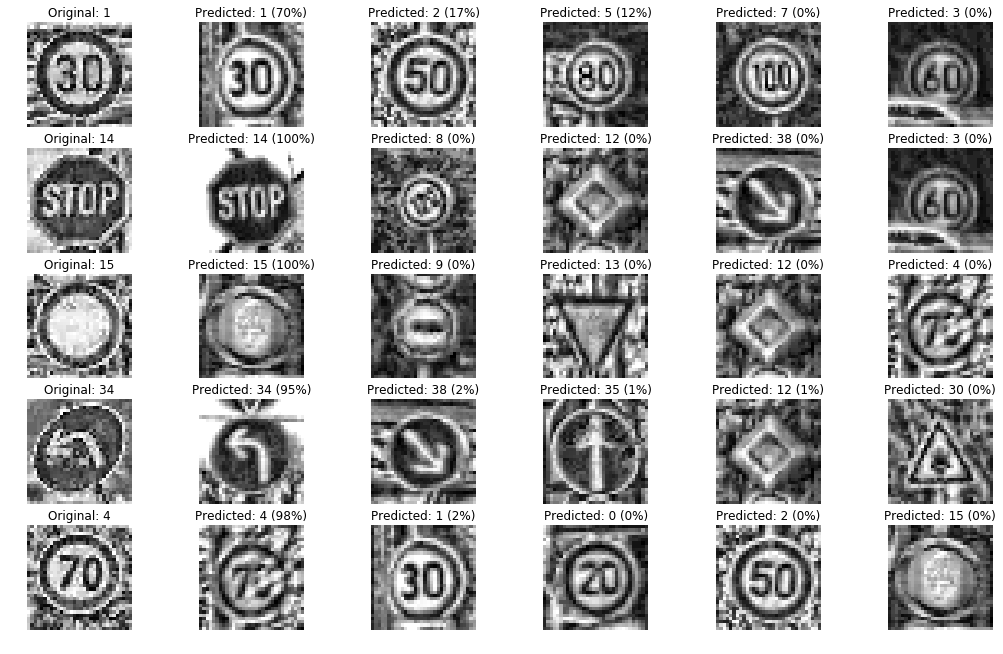

In [31]:
plot_top_k(new_features_normalized, new_classes, top_k_results)

As we can see high level of certainty, along with achieving 100% accuracy, on the newly introduced real-world data is indicative of a model that performs very well.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [32]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, x, keep_prob, keep_prob_value, image_input, tf_activation, activation_min=-1,
                     activation_max=-1, plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x: image_input, keep_prob: keep_prob_value})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15, 15))
    for featuremap in range(featuremaps):
        plt.subplot(6, 8, featuremap + 1)  # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap))  # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min,
                       vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", cmap="gray")
    plt.show()


def plot_feature_map(in_features, in_classes, model_config,
                     keep_prob_value=1.0, load_model=True, conv_name="conv1",
                     model_name="lenet", desc=None, output_dir=OUTPUT_DIRECTORY):
    print(desc)

    if desc is None:
        desc = model_name

    model_file = os.path.join(output_dir, model_name)

    x, y, keep_prob, logits, training_operation, accuracy_operation, cnn_params = model_config()
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if load_model:
            saver.restore(sess, model_file)
        sess = tf.get_default_session()
        outputFeatureMap(sess, x, keep_prob, keep_prob_value, in_features, cnn_params[conv_name])

In [33]:
first_feature = new_features_normalized[0]
first_feature_class = new_classes[0]

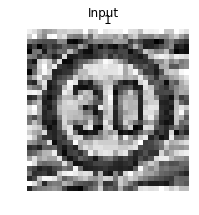

Untrained Model


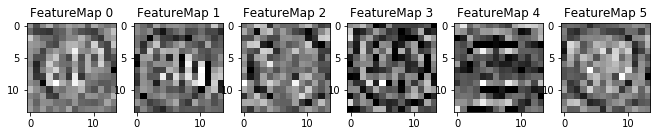

Trained Model


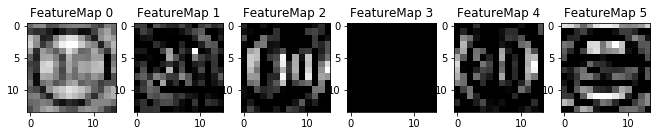

In [34]:
plot_features(np.array([first_feature.squeeze()]), np.array([first_feature_class]), squeeze=False, title="Input")
plot_feature_map(np.array([first_feature]), np.array([first_feature_class]),
                 model_config=model_multi_dropouts_before45_config,
                 desc="Untrained Model",
                 model_name="ndr45_train_images_normalized_model", load_model=False, conv_name="conv1")
plot_feature_map(np.array([first_feature]), np.array([first_feature_class]),
                 model_config=model_multi_dropouts_before45_config,
                 desc="Trained Model",
                 model_name="ndr45_train_images_normalized_model", conv_name="conv1")

On the first picture with untrained model we can see some noisy patterns, which can be an indicator of a network that hasn't been trained. On the second picture with trained model we can see nice and smooth patterns without any noise.